In [92]:
from sklearn.linear_model import LinearRegression

from src.data.dataLoader import StructuralBreakDataLoader
# Structural Break Detection: Basic vs Synthetic Data Generation Approach
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, XGBRegressor
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu, levene, anderson_ksamp
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from src.data.sliding_window_dataset import create_sliding_window_dataset, create_test_windows
from numpy.lib.stride_tricks import sliding_window_view
import warnings
warnings.filterwarnings('ignore')

# Import your existing data loader
import sys
sys.path.append('src')  # Adjust path as needed

In [2]:
data_loader = StructuralBreakDataLoader()
data_loader.load_data(use_crunch=False)

INFO:src.data.dataLoader:Data loaded successfully from local files


(               value  period
 id    time                  
 0     0    -0.005564       0
       1     0.003705       0
       2     0.013164       0
       3     0.007151       0
       4    -0.009979       0
 ...              ...     ...
 10000 2134  0.001137       1
       2135  0.003526       1
       2136  0.000687       1
       2137  0.001640       1
       2138  0.001074       1
 
 [23715734 rows x 2 columns],
 id
 0        False
 1        False
 2         True
 3        False
 4        False
          ...  
 9996     False
 9997     False
 9998     False
 9999     False
 10000     True
 Name: structural_breakpoint, Length: 10001, dtype: bool,
                value  period
 id    time                  
 10001 0     0.010753       0
       1    -0.031915       0
       2    -0.010989       0
       3    -0.011111       0
       4     0.011236       0
 ...              ...     ...
 10101 2002  0.002466       1
       2003  0.010499       1
       2004 -0.026688       1
       200

In [3]:
train_data = data_loader.get_first_n_train_series(10)

In [8]:
train_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
train_data[0]

TimeSeriesData(series_id=0, values=array([-0.00556448,  0.00370513,  0.01316445, ...,  0.01015985,
        0.00108862,  0.00216036], shape=(1645,)), time_points=array([   0,    1,    2, ..., 1642, 1643, 1644], shape=(1645,)), boundary_point=np.int64(1351), period_0_values=array([-0.00556448,  0.00370513,  0.01316445, ...,  0.0027958 ,
        0.00965648,  0.00668773], shape=(1351,)), period_1_values=array([-1.97651807e-02,  1.60380066e-03, -1.25274622e-02,  1.60289429e-03,
        2.76789228e-03,  6.20339562e-03,  7.39299494e-03,  6.72915113e-03,
       -1.16671161e-02, -5.92896081e-03, -5.23927332e-03, -1.96201889e-03,
        7.78133803e-03,  2.21312929e-03, -7.96540950e-03,  9.34355602e-04,
        3.99511449e-04, -5.96957717e-04,  9.57164986e-03,  2.13316433e-04,
        6.16109821e-03, -1.98798851e-03, -4.56136341e-03,  9.63290658e-03,
       -3.18381125e-03, -4.14757093e-03, -7.92851158e-03,  7.72962102e-03,
       -3.04451922e-03,  9.72066935e-06, -2.09010086e-03,  3.05772481e-0

In [10]:
model_ar = LinearRegression()

In [80]:
window_size=8
data = sliding_window_view(train_data[0].values, window_size)
x = data[:-window_size]
y = data[window_size:]
cv = TimeSeriesSplit(n_splits=5)
results = cross_validate(estimator=model_ar, X=x, y=y, cv=cv, scoring='r2')
mean_r2 = np.mean(results["test_score"])
std_r2 = np.std(results["test_score"])

print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

Cross-validated R²: 0.0188 ± 0.0094


In [ ]:
from arch import arch_model

window_size=8
data = sliding_window_view(train_data[0].values, window_size)
x = data[:-window_size]
y = data[window_size:]
cv = TimeSeriesSplit(n_splits=5)

model_ar=arch_model(x=x, p=1, o=1, q=1)

results = cross_validate(estimator=model_ar, X=x, y=y, cv=cv, scoring='r2')
mean_r2 = np.mean(results["test_score"])
std_r2 = np.std(results["test_score"])

print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np

# Parameters
window_size = 1
cv = TimeSeriesSplit(n_splits=5)

# Prepare data
data = sliding_window_view(train_data[0].values, window_size)
x = data[:-window_size]
y = data[window_size:]

# Define model
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Cross-validation
results = cross_validate(estimator=model_rf, X=x, y=y, cv=cv, scoring='r2')

# Mean & std of R²
mean_r2 = np.mean(results["test_score"])
std_r2 = np.std(results["test_score"])

print(f"Random Forest Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")


Random Forest Cross-validated R²: -0.3767 ± 0.0904


In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np

# Parameters
window_size = 10
cv = TimeSeriesSplit(n_splits=5)

# Prepare data
data = sliding_window_view(train_data[0].values, window_size)
data = np.abs(data)
x = data[:-window_size]
y = data[window_size:]

# Define model
model_rf = XGBRegressor(learning_rate=0.001)

# Cross-validation
results = cross_validate(estimator=model_rf, X=x, y=y, cv=cv, scoring='r2')

# Mean & std of R²
mean_r2 = np.mean(results["test_score"])
std_r2 = np.std(results["test_score"])

print(f"Random Forest Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")


Random Forest Cross-validated R²: -0.0104 ± 0.0151


<Axes: >

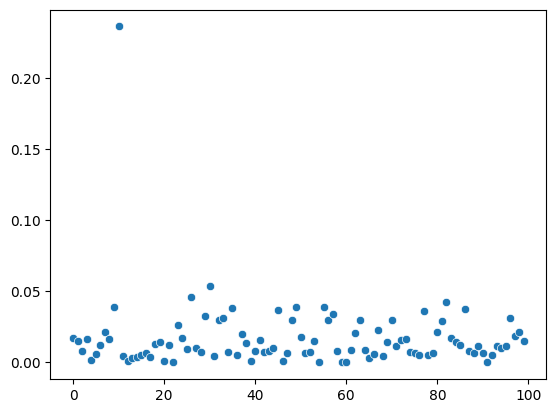

In [137]:
import seaborn as sns
sns.scatterplot(np.abs(train_data[5].values)[:100])